# Analyzing the model's predictions

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sb
import sys
import statsmodels.stats.api as sms
from scipy.stats import t


#sys.path.append(os.path.realpath('./AugmentedSocialScientist'))
# WARNING : Make sure that your current working directory (cwd) is `ReproducingAugSS/AugmentedSocialScientist/`
# If it is not the case, use
# os.chdir('..')
# or 
sys.path.append(os.path.realpath('..'))

from PATHS import DATAPATH, ENDOEXO_GS

## Transforming from model logs to lighter logs (in terms of memory)

Explanation : the model's predictions on the Policy / Politics task are logged **sentence by sentence** which is extremely ineffective in terms of memory. This choice is due to our policy/politics model which works sentence by sentence. 

We first recompile a database with ```article->annotated spans of sents for the whole article``` instead of ```sent -> label```

We already have a column ```pred_labels```which contains spans for the whole article, so we just have to drop text duplicates and do some cleaning on spans & labels

**WARNING**: You have to run `python AugmentedSocialScientist/predict/predict_logged_models.py` first to obtains the predictions files. Otherwise, you can also skip the following code cell and use directly the lightened prediction files (which are produced by the following code cell).

In [2]:
PRED_PATH_PP = glob(os.path.join(DATAPATH, 'AugmentedSocialScientist/predicted_files_pp/LeMonde_*.csv'))

# Dictionnary that converts labels' codes to their names
inv_conv_dict = {"1" : "Policy",
                 "0" : "Politics",
                 "2" : 'Other'}

# Iterating on decades per decades preds datasets
for path in tqdm_notebook(PRED_PATH_PP):
    df = pd.read_csv(path).drop_duplicates('text')
    df['labels'] = df.pred_labels.apply(lambda x: list(map(lambda y: [max(0, y[0]-5), y[1]-5, inv_conv_dict[str(int(y[2]))]], eval(x))) if len(x)>0 else [])
    df['labels'] = df.labels.apply(lambda x: sorted(list(map(lambda y : list(y),list(set(map(tuple, x))))) , key = lambda z: z[0]))
    df = df[['text', 'labels', 'journal', 'auteurs', 'date', 'titre', 'annee', 'nbmots', 'auteurs2', 'decennie']]
    df.to_csv(path.replace('LeMonde', 'light_LeMonde'))

/scratch/users/r/rshen/ipykernel_23939/3172245330.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for path in tqdm_notebook(PRED_PATH_PP):


0it [00:00, ?it/s]

In [3]:
df

NameError: name 'df' is not defined

## Perfomance metrics

In [3]:
from collections import defaultdict

In [4]:
gs = pd.read_csv(ENDOEXO_GS)
gs.labels = gs.labels.apply(eval)

In [5]:
dict_prec={'politics':0.75,'policy':0.80,'other':0.48}
dict_recall={'politics':0.75,'policy':0.83,'other':0.26}

In [6]:
lab_counts = defaultdict(int)
for labs in gs.labels:
    for lab in labs:
        lab_counts[lab[2]] += lab[1]-lab[0]
lab_counts = dict(zip(['other','politics','policy'],lab_counts.values()))
n_total = sum(lab_counts.values())

In [7]:
dict_FOR = {}  #false omission rate
for lab in ['politics','policy','other']:
    tp = lab_counts[lab]*dict_recall[lab]
    fn = lab_counts[lab]-tp
    fp = tp*(1/dict_prec[lab]-1)
    tn = n_total - tp - fp - fn
    dict_FOR[lab] = fn/(tn+fn)

## Load lightened prediction files

In [8]:
ls_df=[]
for path in glob(os.path.join(DATAPATH, 'AugmentedSocialScientist/predicted_files_pp/light_LeMonde_*.csv')):
    ls_df.append(pd.read_csv(path,index_col=0))
    
df2 = pd.concat(ls_df)

In [9]:
df2.labels = df2.labels.apply(eval)
df2 = df2.rename({'annee':'year'},axis=1)

We now compile the database containing for each article, the % of characters that are classified as Policy vs. politics

In [10]:
df2 = df2[['text', 'labels', "year"]]
df2['nb_char'] = df2.text.apply(len)

def nb_char_cat(labels):
    c = {'Policy':0,
        'Politics': 0,
        'Other': 0}
    for l in labels:
        span1, span2, lab = l
        length = span2-span1
        c[lab]+= length
    return c
    
df2['nb_char_cat'] = df2.labels.apply(nb_char_cat)
#df2['test'] = df2.apply(lambda x:  100*(x.nb_char - sum(list(x.nb_char_cat.values())))/x.nb_char , axis=1)

for label in ['Policy', 'Politics', 'Other']:
    df2[f'Prec_{label}'] = df2['nb_char_cat'].apply(lambda x: x[label])/df2['nb_char']

In [10]:
#predicted average and confidence interval
df3 = df2.groupby('year')['Prec_Policy','Prec_Politics','Prec_Other'].agg([np.mean, lambda g:sms.DescrStatsW(g).tconfint_mean()[0],lambda g:sms.DescrStatsW(g).tconfint_mean()[1]])
df3.columns = [f'{label}_{x}' for label in ['policy', 'politics', 'other'] for x in ['mean','lower','upper']]

/scratch/users/r/rshen/ipykernel_25720/133211381.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df3 = df2.groupby('year')['Prec_Policy','Prec_Politics','Prec_Other'].agg([np.mean, lambda g:sms.DescrStatsW(g).tconfint_mean()[0],lambda g:sms.DescrStatsW(g).tconfint_mean()[1]])


In [11]:
#transform to real average and confidence interval with the relation: real = FOR + (precision-FOR)*predicted
for label in ['policy', 'politics', 'other']:
    df3[label+'_mean'] = dict_FOR[label] + (dict_prec[label]-dict_FOR[label])* df3[label+'_mean']
    df3[label+'_upper'] = dict_FOR[label] + (dict_prec[label]-dict_FOR[label])* df3[label+'_upper']
    df3[label+'_lower'] = dict_FOR[label] + (dict_prec[label]-dict_FOR[label])* df3[label+'_lower']

In [12]:
df3 = df3.reset_index()

In [16]:
pd.options.display.max_rows=100
df3

,year,policy_mean,policy_lower,policy_upper,politics_mean,politics_lower,politics_upper,other_mean,other_lower,other_upper
0,1945,0.538590,0.516811,0.560368,0.346185,0.323266,0.369104,0.097370,0.081627,0.113114
1,1946,0.528166,0.512814,0.543518,0.381369,0.364512,0.398226,0.079725,0.074730,0.084720
2,1947,0.541800,0.527802,0.555798,0.358110,0.342826,0.373393,0.086089,0.080279,0.091899
3,1948,0.551110,0.538389,0.563831,0.360372,0.346792,0.373952,0.077147,0.072778,0.081516
4,1949,0.542524,0.526108,0.558940,0.372207,0.354509,0.389905,0.075043,0.069716,0.080369
5,1950,0.619304,0.600130,0.638478,0.314176,0.294181,0.334172,0.058522,0.056370,0.060675
6,1951,0.585029,0.567063,0.602996,0.349815,0.330964,0.368667,0.058492,0.056667,0.060316
7,1952,0.635363,0.621056,0.649670,0.295555,0.280600,0.310510,0.059781,0.057528,0.062035
8,1953,0.579885,0.563013,0.596756,0.355270,0.337714,0.372826,0.058601,0.056076,0.061126
9,1954,0.582383,0.569705,0.595062,0.344887,0.331458,0.358315,0.064506,0.061927,0.067084


/scratch/users/r/rshen/ipykernel_13953/2429763916.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


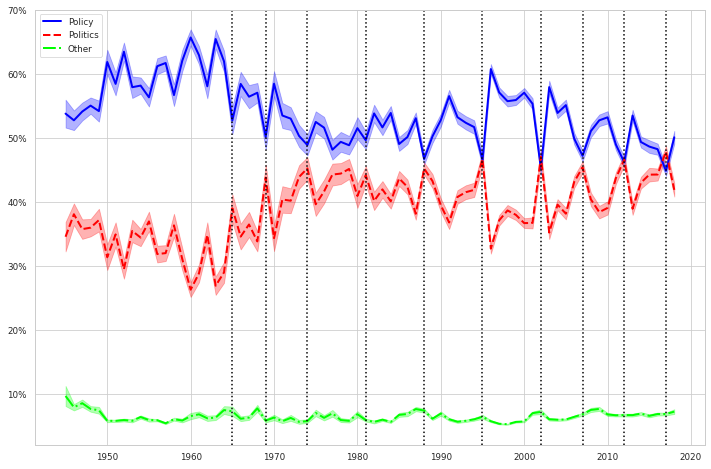

In [358]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

%matplotlib inline
sb.set_context("paper")
sb.set_palette("hls", 8)
sb.set_style("whitegrid")

fig = plt.figure(figsize=(12,8))

plt.plot(df3['year'],df3['policy_mean'], color=(0,0,1),label='Policy',linestyle='-',linewidth=2)
plt.fill_between(df3['year'], df3['policy_upper'], df3['policy_lower'],color=(0,0,1,0.3))
plt.plot(df3['year'],df3['politics_mean'], color=(1,0,0),label='Politics',linestyle='--',linewidth=2)
plt.fill_between(df3['year'], df3['politics_upper'], df3['politics_lower'],color=(1,0,0,0.3))
plt.plot(df3['year'],df3['other_mean'], color=(0,1,0),label='Other',linestyle='-.',linewidth=2)
plt.fill_between(df3['year'], df3['other_upper'], df3['other_lower'],color=(0,1,0,0.3))


elec_pres = [1965, 1969, 1974, 1981, 1988, 1995, 2002, 2007, 2012, 2017]
for xc in elec_pres:
    plt.axvline(x=xc, color='black', linestyle=':',linewidth=1.5)
    
plt.xlabel('')
plt.ylabel('')
plt.legend(title='')
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.show()